<a href="https://colab.research.google.com/github/AbdulSheffa/IRP/blob/main/FYP_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Self-Supervised CycleGAN for Single Image De-Raining

## Pre-requisuites

> Importing required libraries



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd pytorch-CycleGAN-and-pix2pix


Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 11.86 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
/content/pytorch-CycleGAN-and-pix2pix


In [3]:
!pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.5 MB/s eta 0:00:00
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha

In [4]:
pip install pytorch_msssim

## Model Architecture


> Define the Generator and Discriminator Architecture
> Implement Function for the Dynamic maksing to the dataset





In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
from models.networks import ResnetGenerator, NLayerDiscriminator
import pytorch_msssim

# 1.  Define custom Dataset class with Dynamic Masking
#     Applies random rectangular masks to simulate rain occlusion and guide self-supervised learning

class RainDatasetSSL(Dataset):
    """Implements dynamic masking during training for unsupervised learning."""

    def __init__(self, dataset_name, input_dir, target_dir, transform=None, sample_size=None, output_dir=None, save_masked=False, epoch=0):
        self.dataset_name = dataset_name
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.output_dir = output_dir
        self.save_masked = save_masked
        self.epoch = epoch

        self.input_images = sorted(os.listdir(input_dir))
        self.target_images = sorted(os.listdir(target_dir))

        if sample_size:
            indices = random.sample(range(len(self.input_images)), sample_size)
            self.input_images = [self.input_images[i] for i in indices]
            self.target_images = [self.target_images[i] for i in indices]

        if save_masked and output_dir:
            os.makedirs(output_dir, exist_ok=True)
            self.masked_images_to_save = random.sample(self.input_images, min(10, len(self.input_images)))

    def __len__(self):
        return len(self.input_images)

    def mask_image(self, img_tensor, img_name):
        """Apply Random masking for self-supervised learning & save masked image if required."""
        if img_tensor.dim() == 4:  # If batch, process each image separately
            return torch.stack([self.mask_image(single_img, img_name) for single_img in img_tensor])

        if img_tensor.dim() != 3:
            raise ValueError(f"Unexpected tensor shape {img_tensor.shape}, expected (C, H, W)")

        _, h, w = img_tensor.shape
        mask_size = (random.randint(h // 6, h // 4), random.randint(w // 6, w // 4))
        x, y = random.randint(0, h - mask_size[0]), random.randint(0, w - mask_size[1])

        masked_tensor = img_tensor.clone()
        masked_tensor[:, x:x + mask_size[0], y:y + mask_size[1]] = -1

        # Ensure the output directory exists before saving
        if self.save_masked and self.output_dir:
            os.makedirs(self.output_dir, exist_ok=True)  # Ensure the directory exists

            save_path = os.path.join(self.output_dir, f"masked_{self.dataset_name}_epoch_{self.epoch}_{img_name}")
            save_image((masked_tensor + 1) / 2, save_path)  # Denormalizing before saving

        return masked_tensor


    def __getitem__(self, idx):
        input_img_path = os.path.join(self.input_dir, self.input_images[idx])
        target_img_path = os.path.join(self.target_dir, self.target_images[idx])

        input_image = Image.open(input_img_path).convert("RGB")
        target_image = Image.open(target_img_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        masked_image = self.mask_image(input_image.clone(), self.input_images[idx])
        return masked_image, input_image, target_image, self.input_images[idx]


ssim_loss_fn = pytorch_msssim.SSIM(data_range=1.0, size_average=True, channel=3)

class DeRainCycleGANSSL:
    """Self-supervised CycleGAN-based framework for single-image de-raining."""

    def __init__(self, input_nc, output_nc, ngf, ndf, device, total_epochs=60):
        self.device = device
        self.total_epochs = total_epochs
        self.netG_A = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=nn.InstanceNorm2d, n_blocks=9).to(device)
        self.netG_B = ResnetGenerator(output_nc, input_nc, ngf).to(device)
        self.netD_A = NLayerDiscriminator(output_nc, ndf).to(device)
        self.netD_B = NLayerDiscriminator(input_nc, ndf).to(device)

        self.criterionGAN = nn.MSELoss()
        self.criterionCycle = nn.L1Loss()
        self.criterionPerceptual = nn.L1Loss()

        self.vgg19 = models.vgg19(pretrained=True).features[:30].eval().to(device)
        for param in self.vgg19.parameters():
            param.requires_grad = False

        self.optimizer_G = torch.optim.Adam(
            list(self.netG_A.parameters()) + list(self.netG_B.parameters()), lr=0.0001, betas=(0.5, 0.999)
        )

        self.optimizer_D = torch.optim.Adam(
            list(self.netD_A.parameters()) + list(self.netD_B.parameters()), lr=0.00005, betas=(0.5, 0.999)
        )


    def perceptual_loss(self, x, y):
        return self.criterionPerceptual(self.vgg19(x), self.vgg19(y))

    def forward(self, real_A, real_B):
        fake_B = self.netG_A(real_A)
        rec_A = self.netG_B(fake_B)
        fake_A = self.netG_B(real_B)
        rec_B = self.netG_A(fake_A)
        return fake_B, rec_A, fake_A, rec_B

    def optimize_parameters(self, real_A, real_B, scaler, epoch):
        """Optimizes generator and discriminator parameters for one iteration."""

        #  Adaptive Cycle Weight
        cycle_weight = max(1.0, 3.0 * (1.0 - epoch / self.total_epochs))

        self.optimizer_G.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            real_A, real_B = real_A.half(), real_B.half()
            fake_B, rec_A, fake_A, rec_B = self.forward(real_A, real_B)

            # Adverserial Losses
            loss_G_A = self.criterionGAN(self.netD_A(fake_B), torch.ones_like(self.netD_A(fake_B)))
            loss_G_B = self.criterionGAN(self.netD_B(fake_A), torch.ones_like(self.netD_B(fake_A)))

            # Cycle-consistency losses
            loss_cycle_A = self.criterionCycle(rec_A, real_A) * cycle_weight
            loss_cycle_B = self.criterionCycle(rec_B, real_B) * cycle_weight

            # Perceptual loss (High-level feature similarity using VGG19)
            loss_perceptual = self.perceptual_loss(fake_B, real_B) * 0.3

            # Pixel-level L1 loss (Reconstruction loss)
            loss_L1 = self.criterionCycle(fake_B, real_B) * 2.0

            #  SSIM Loss
            loss_ssim = (1 - ssim_loss_fn(denormalize(fake_B), denormalize(real_B))) * 1

            # Total Generator loss (weighted sum of all components)
            loss_G = 2.0 * loss_G_A + 2.0 * loss_G_B + 4.0 * loss_cycle_A + 4.0 * loss_cycle_B + 0.5 * loss_perceptual + loss_L1 + loss_ssim

        scaler.scale(loss_G).backward()
        scaler.step(self.optimizer_G)
        scaler.update()

        self.optimizer_D.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):

            loss_D_A = self.criterionGAN(self.netD_A(real_B.half()), torch.ones_like(self.netD_A(real_B.half())))
            loss_D_B = self.criterionGAN(self.netD_B(real_A.half()), torch.ones_like(self.netD_B(real_A.half())))
            loss_D = (loss_D_A + loss_D_B) * 0.3

        scaler.scale(loss_D).backward()
        scaler.step(self.optimizer_D)
        scaler.update()

        return loss_G.detach(), loss_D_A.detach(), loss_D_B.detach(), loss_ssim.detach()


## Training Loop

In [ ]:
import os
import torch
import torch.nn as nn
import torch.cuda.amp as amp  # Mixed Precision Training
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from torch.utils.data import DataLoader
from models.networks import ResnetGenerator
import time

# Define Paths
checkpoint_dir = "/content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/"

# Dataset Configuration Dictionary
# Defines the paths and parameters for training on three types
# of rain intensity from the DID-MDN dataset: Heavy, Medium, Light.
# Each entry includes:
# - 'input'  : Path to rainy images
# - 'target' : Path to corresponding clean images
# - 'output' : Directory to save model outputs
# - 'batch_size' and 'sample_size' for training control

datasets = {
    "DID-MDN-Heavy": {
        "input": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Rain_Heavy/rainy",
        "target": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Rain_Heavy/non_rainy",
        "output": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Heavy-rain/results_17/",
        "batch_size": 8,
        "sample_size": 150
    },
      "DID-MDN-Medium": {
          "input": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Rain_Medium/rainy",
          "target": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Rain_Medium/non_rainy",
          "output": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Medium-rain/results_17/",
          "batch_size": 8,
          "sample_size": 110
          },
      "DID-MDN-Light": {
          "input": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Rain_Light/rainy",
          "target": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Rain_Light/non_rainy",
          "output": "/content/drive/MyDrive/Khabeer - IRP/Dataset/DID-MDN-datasets/DID-MDN-training-split/Light-rain/results_1/",
          "batch_size": 8,
          "sample_size": 150
          }
}

# Image Transformations.clamp(0, 1)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def denormalize(tensor):
    return (tensor + 1) / 2

# Initialize Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Model
model = DeRainCycleGANSSL(input_nc=3, output_nc=3, ngf=128, ndf=256, device=device)

# Learning Rate Schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(model.optimizer_G, step_size=30, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(model.optimizer_D, step_size=30, gamma=0.5)


def load_latest_checkpoint(model, checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_epoch_") and f.endswith(".pth")]

    if not checkpoint_files:
        print(" No valid checkpoint found. Starting from scratch.")
        # Start from epoch 0
        return 0

    # Filter only files with numeric epoch values
    valid_checkpoints = []
    for file in checkpoint_files:
        try:
            epoch_num = int(file.split("_")[-1].split(".")[0])  # Extract epoch number
            valid_checkpoints.append((epoch_num, file))
        except ValueError:
            continue  # Skip files that don't have a valid number

    if not valid_checkpoints:
        print("No properly formatted checkpoint files found. Starting from scratch.")
        return 0

    # Get the latest checkpoint by epoch number
    latest_checkpoint = max(valid_checkpoints, key=lambda x: x[0])[1]
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

    # Load Checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.netG_A.load_state_dict(checkpoint['model_G_A_state_dict'])
    model.netG_B.load_state_dict(checkpoint['model_G_B_state_dict'])
    model.netD_A.load_state_dict(checkpoint['model_D_A_state_dict'])
    model.netD_B.load_state_dict(checkpoint['model_D_B_state_dict'])
    model.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    model.optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

    print(f"Loaded checkpoint from: {checkpoint_path}")

    # Resume from next epoch

    return checkpoint['epoch'] + 1

training_log_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/training_time_log_heavy.txt"
if not os.path.exists(training_log_path):
    open(training_log_path, "w").close()

# Start tracking total training time
total_training_start = time.time()

# SSIM Loss Storage
ssim_losses = []

# Resume Training from Latest Checkpoint
start_epoch = load_latest_checkpoint(model, checkpoint_dir)
num_epochs = 50
fine_tune_lr_G = 0.00003
fine_tune_lr_D = 0.00001


# LR for Generators
for param_group in model.optimizer_G.param_groups:
    param_group['lr'] = fine_tune_lr_G

# Update LR for Discriminators
for param_group in model.optimizer_D.param_groups:
    param_group['lr'] = fine_tune_lr_D

# Training Loop
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())

total_training_start = time.time()

for dataset_name, paths in datasets.items():
    print(f"Fine-tuning on {dataset_name} dataset...")

    input_dir = paths["input"]
    target_dir = paths["target"]
    output_dir = paths["output"]
    batch_size = paths["batch_size"]
    sample_size = paths["sample_size"]

    os.makedirs(output_dir, exist_ok=True)

    # Load dataset
    train_loader = DataLoader(
        RainDatasetSSL(
            dataset_name=dataset_name,
            input_dir=input_dir,
            target_dir=target_dir,
            transform=transform,
            sample_size=sample_size,
            output_dir=output_dir,
            save_masked=True
        ),
        batch_size=batch_size,
        shuffle=True
    )

    for epoch in range(start_epoch, num_epochs + start_epoch):
        epoch_start = time.time()
        for i, (masked_A, real_A, real_B, img_name) in enumerate(train_loader):
            masked_A, real_A, real_B = masked_A.to(device), real_A.to(device), real_B.to(device)
            batch_start = time.time()
            # Optimize Model
            loss_G, loss_D_A, loss_D_B, loss_ssim = model.optimize_parameters(masked_A, real_B, scaler, epoch)
            batch_time = time.time() - batch_start

            # Store SSIM Loss for Averaging
            ssim_losses.append(loss_ssim.item())

            if torch.isnan(loss_G).any() or torch.isnan(loss_D_A).any() or torch.isnan(loss_D_B).any():
                print("NaN detected in loss! Skipping update.")
                continue

            print(f"Epoch {epoch}/{num_epochs}, Batch {i}/{len(train_loader)}, Image: {img_name[0]}, "
                  f"Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}, "
                  f"SSIM Loss: {loss_ssim.item():.4f}, Batch Time: {batch_time:.2f}s")


        epoch_time = time.time() - epoch_start  # Time taken for this epoch
        print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds.")

        # Log training time per epoch
        with open(training_log_path, "a") as log_file:
            log_file.write(f"Epoch {epoch}, Time: {epoch_time:.2f}s, Loss_G: {loss_G.item():.4f}, "
                           f"Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}, SSIM Loss: {loss_ssim.item():.4f}\n")

        scheduler_G.step()
        scheduler_D.step()

        torch.cuda.empty_cache()

        # Save checkpoint every 5 epochs
        if epoch % 5 == 0 or epoch == (num_epochs + start_epoch - 1):
            save_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
            torch.save({
                'epoch': epoch,
                'model_G_A_state_dict': model.netG_A.state_dict(),
                'model_G_B_state_dict': model.netG_B.state_dict(),
                'model_D_A_state_dict': model.netD_A.state_dict(),
                'model_D_B_state_dict': model.netD_B.state_dict(),
                'optimizer_G_state_dict': model.optimizer_G.state_dict(),
                'optimizer_D_state_dict': model.optimizer_D.state_dict(),
                'scheduler_G_state_dict': scheduler_G.state_dict(),
                'scheduler_D_state_dict': scheduler_D.state_dict(),
                'scaler_state_dict': scaler.state_dict()
            }, save_path)
            print(f"Checkpoint saved at epoch {epoch}")

    # Save final generated images
    if epoch == num_epochs + start_epoch - 1:
        model.netG_A.eval()
        with torch.no_grad():
            for i, (masked_A, _, _, img_names) in enumerate(train_loader):
                masked_A = masked_A.to(device)
                fake_B = model.netG_A(masked_A)

                # Apply Denormalization
                fake_B = denormalize(fake_B).clamp(0, 1)

                for j in range(real_A.size(0)):
                    img_name = img_names[j]
                    save_path = os.path.join(output_dir, f"{dataset_name}_fine_tuned_{img_name}")

                    # Convert to PIL and Save
                    to_pil_image(fake_B[j].detach().cpu()).save(save_path)

                    print(f"Saved: {save_path}")

final_avg_ssim = sum(ssim_losses) / len(ssim_losses) if ssim_losses else 0.0

# Log Final Average SSIM
print(f"Final Average SSIM Loss: {final_avg_ssim:.4f}")
with open(training_log_path, "a") as log_file:
    log_file.write(f"\nFinal Average SSIM Loss: {final_avg_ssim:.4f}\n")

# Log total training time
total_time = time.time() - total_training_start
print(f"Total Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

print("Fine-tuning completed successfully!")

# Convert to PIL and Save
to_pil_image(fake_B[j].detach().cpu()).save(save_path)

print(f"Saved: {save_path}")



Using device: cuda
Loaded checkpoint from: /content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/checkpoint_epoch_300.pth
Fine-tuning on DID-MDN-Light dataset...
Epoch 301/50, Batch 0/19, Image: rainy_566.jpg, Loss_G: 1.7790, Loss_D_A: 0.0007, Loss_D_B: 0.0005, SSIM Loss: 0.3600, Batch Time: 4.21s
Epoch 301/50, Batch 1/19, Image: rainy_3380.jpg, Loss_G: 1.6699, Loss_D_A: 0.0012, Loss_D_B: 0.0015, SSIM Loss: 0.2580, Batch Time: 3.01s
Epoch 301/50, Batch 2/19, Image: rainy_942.jpg, Loss_G: 1.4423, Loss_D_A: 0.0008, Loss_D_B: 0.0014, SSIM Loss: 0.2538, Batch Time: 3.01s
Epoch 301/50, Batch 3/19, Image: rainy_3974.jpg, Loss_G: 1.9599, Loss_D_A: 0.0010, Loss_D_B: 0.0010, SSIM Loss: 0.3436, Batch Time: 3.03s
Epoch 301/50, Batch 4/19, Image: rainy_3961.jpg, Loss_G: 1.5105, Loss_D_A: 0.0007, Loss_D_B: 0.0007, SSIM Loss: 0.2731, Batch Time: 3.01s
Epoch 301/50, Batch 5/19, Image: rainy_3196.jpg, Loss_G: 1.3958, Loss_D_A: 0.0012, Loss_D_B: 0.0007, SSIM Loss: 0.2762, Batch Time: 3.01s
Epoch 30

In [ ]:
# Save Final Checkpoint
# Stores the full training state at the end of all epochs
# Ensures the model can be resumed or used for inference later.

final_checkpoint_path = os.path.join(checkpoint_dir, "final_trained_model_1.pth")

torch.save({
    'epoch': num_epochs,
    'model_G_A_state_dict': model.netG_A.state_dict(),
    'model_G_B_state_dict': model.netG_B.state_dict(),
    'model_D_A_state_dict': model.netD_A.state_dict(),
    'model_D_B_state_dict': model.netD_B.state_dict(),
    'optimizer_G_state_dict': model.optimizer_G.state_dict(),
    'optimizer_D_state_dict': model.optimizer_D.state_dict(),
    'scheduler_G_state_dict': scheduler_G.state_dict(),
    'scheduler_D_state_dict': scheduler_D.state_dict(),
    'scaler_state_dict': scaler.state_dict()
}, final_checkpoint_path)

print(f"Final trained model saved at: {final_checkpoint_path}")


In [ ]:
import torch
# Load the model
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("/content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/final_trained_model_1.pth", map_location=device)
model = DeRainCycleGANSSL(input_nc=3, output_nc=3, ngf=128, ndf=256, device=device)
scaler = torch.amp.GradScaler("cuda")
# Learning Rate Schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(model.optimizer_G, step_size=30, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(model.optimizer_D, step_size=30, gamma=0.5)

model.netG_A.load_state_dict(checkpoint['model_G_A_state_dict'])
model.netG_B.load_state_dict(checkpoint['model_G_B_state_dict'])
model.netD_A.load_state_dict(checkpoint['model_D_A_state_dict'])
model.netD_B.load_state_dict(checkpoint['model_D_B_state_dict'])

# Load optimizers & scaler (if resuming training)
model.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
model.optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
scheduler_G.load_state_dict(checkpoint['scheduler_G_state_dict'])
scheduler_D.load_state_dict(checkpoint['scheduler_D_state_dict'])
scaler.load_state_dict(checkpoint['scaler_state_dict'])


In [ ]:
# Paths to your log files
file1 = "/content/drive/MyDrive/Khabeer - IRP/Dataset/training_time_log.txt"
file2 = "/content/drive/MyDrive/Khabeer - IRP/Dataset/training_time_log_heavy.txt"
merged_file = "/content/drive/MyDrive/Khabeer - IRP/Dataset/model_training_log.txt"

# Combine both logs
with open(merged_file, 'w') as outfile:
    for fname in [file1, file2]:
        with open(fname) as infile:
            outfile.write(infile.read())

print(" Merged file saved as:", merged_file)


 Merged file saved as: /content/drive/MyDrive/Khabeer - IRP/Dataset/model_training_log.txt


## Evaluation


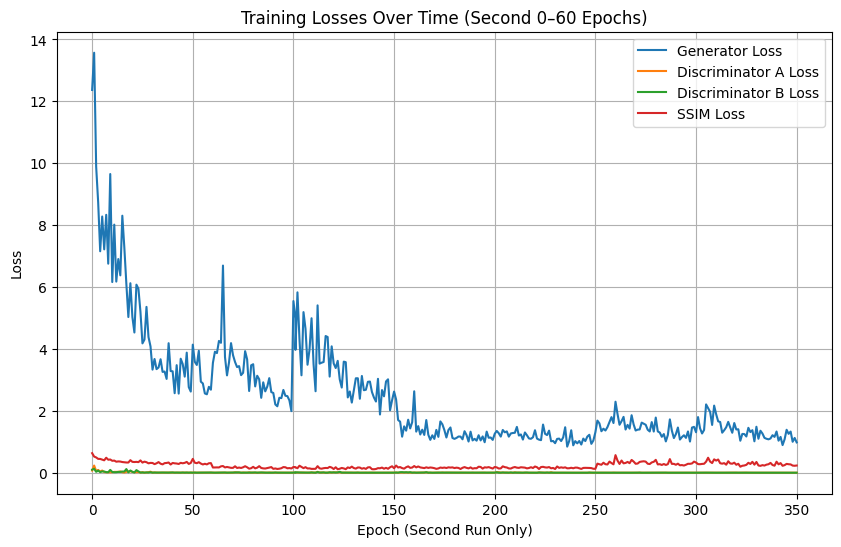

In [ ]:
log_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/model_training_log.txt"

# Read all lines
with open(log_path, 'r') as f:
    lines = f.readlines()

# Find indexes of where "Epoch 0" appears
epoch_zeros = [i for i, line in enumerate(lines) if line.strip().startswith("Epoch 0")]

# If two "Epoch 0" found, keep only the second set of logs
if len(epoch_zeros) >= 3:
    second_run_start = epoch_zeros[2]
    lines = lines[second_run_start:]  # Keep logs only from the second run

# Parse the cleaned logs
epochs, loss_G, loss_D_A, loss_D_B, ssim_loss = [], [], [], [], []

for line in lines:
    if "Epoch" in line and "Loss_G" in line:
        parts = line.strip().split(", ")
        try:
            epoch_num = int(parts[0].split(" ")[1])
            loss_g = float(parts[2].split(": ")[1])
            loss_d_a = float(parts[3].split(": ")[1])
            loss_d_b = float(parts[4].split(": ")[1])
            ssim = float(parts[5].split(": ")[1])

            epochs.append(epoch_num)
            loss_G.append(loss_g)
            loss_D_A.append(loss_d_a)
            loss_D_B.append(loss_d_b)
            ssim_loss.append(ssim)
        except:
            continue  # Skip lines that don't match format

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_G, label='Generator Loss')
plt.plot(epochs, loss_D_A, label='Discriminator A Loss')
plt.plot(epochs, loss_D_B, label='Discriminator B Loss')
plt.plot(epochs, ssim_loss, label='SSIM Loss')
plt.xlabel("Epoch (Second Run Only)")
plt.ylabel("Loss")
plt.title("Training Losses Over Time (Second 0–60 Epochs)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
log_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/model_training_log.txt"

# Read all lines
with open(log_path, 'r') as f:
    lines = f.readlines()

# Find indexes of where "Epoch 0" appears
epoch_zeros = [i for i, line in enumerate(lines) if line.strip().startswith("Epoch 0")]

# If two "Epoch 0" found, keep only the second set of logs
if len(epoch_zeros) >= 3:
    second_run_start = epoch_zeros[2]
    lines = lines[second_run_start:]  # Keep logs only from the second run

# Parse the cleaned logs
epochs, loss_G, loss_D_A, loss_D_B, ssim_loss, times = [], [], [], [], [], []

for line in lines:
    if "Epoch" in line and "Loss_G" in line:
        parts = line.strip().split(", ")
        try:
            epoch_num = int(parts[0].split(" ")[1])
            loss_g = float(parts[2].split(": ")[1])
            loss_d_a = float(parts[3].split(": ")[1])
            loss_d_b = float(parts[4].split(": ")[1])
            ssim = float(parts[5].split(": ")[1])
            time = float(parts[1].split(": ")[1].replace("s", ""))  # Extract the time (remove "s")

            epochs.append(epoch_num)
            loss_G.append(loss_g)
            loss_D_A.append(loss_d_a)
            loss_D_B.append(loss_d_b)
            ssim_loss.append(ssim)
            times.append(time)
        except:
            continue  # Skip lines that don't match format

# Calculate the total time for each epoch range
time_ranges = {
    '0-60': sum(times[:61]),
    '60-100': sum(times[60:101]),
    '150-200': sum(times[150:201]),
    '200-250': sum(times[200:251]),
    '250-300': sum(times[250:301]),
    '300-350': sum(times[300:351]),
}

# Output the time ranges
print(time_ranges)


{'0-60': 3169.439999999999, '60-100': 2068.09, '150-200': 5290.670000000001, '200-250': 5305.52, '250-300': 2493.03, '300-350': 3268.7300000000005}


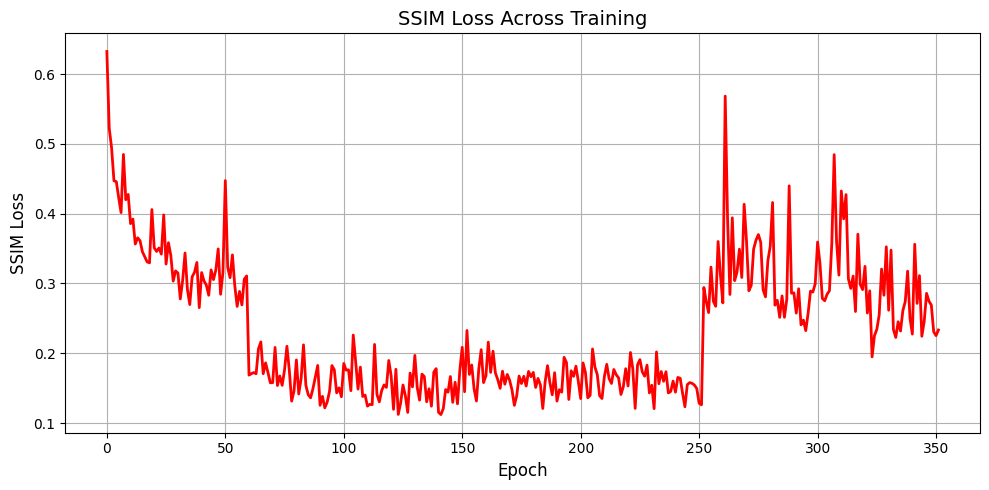

In [ ]:
import matplotlib.pyplot as plt

log_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/model_training_log.txt"

# Read all lines
with open(log_path, 'r') as f:
    lines = f.readlines()

# Find indexes where "Epoch 0" appears
epoch_zeros = [i for i, line in enumerate(lines) if line.strip().startswith("Epoch 0")]

# If multiple training runs found, keep only from latest "Epoch 0"
if len(epoch_zeros) >= 3:
    second_run_start = epoch_zeros[2]
    lines = lines[second_run_start:]

# Parse training logs
epochs, loss_G, loss_D_A, loss_D_B, ssim_loss = [], [], [], [], []

for line in lines:
    if "Epoch" in line and "Loss_G" in line:
        parts = line.strip().split(", ")
        try:
            epoch_num = int(parts[0].split(" ")[1])
            loss_g = float(parts[2].split(": ")[1])
            loss_d_a = float(parts[3].split(": ")[1])
            loss_d_b = float(parts[4].split(": ")[1])
            ssim = float(parts[5].split(": ")[1])

            epochs.append(epoch_num)
            loss_G.append(loss_g)
            loss_D_A.append(loss_d_a)
            loss_D_B.append(loss_d_b)
            ssim_loss.append(ssim)
        except:
            continue  # skip any malformed line

# 📈 Plot SSIM Loss Over Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(len(ssim_loss)), ssim_loss, color='red', linewidth=2)
plt.title("SSIM Loss Across Training", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("SSIM Loss", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


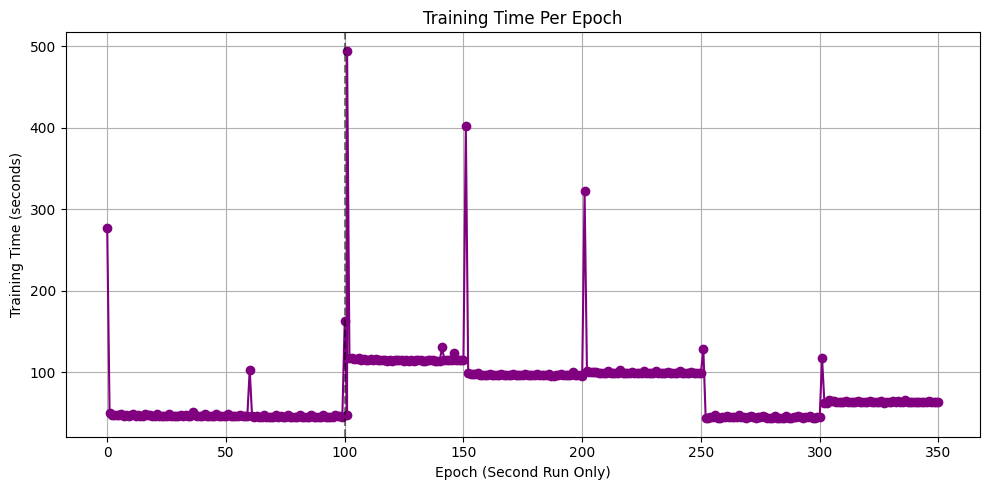

In [ ]:
log_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/model_training_log.txt"

# Read all lines
with open(log_path, 'r') as f:
    lines = f.readlines()

# Find indexes of where "Epoch 0" appears
epoch_zeros = [i for i, line in enumerate(lines) if line.strip().startswith("Epoch 0")]

# If two or more "Epoch 0" found, keep only the second or third run
if len(epoch_zeros) >= 3:
    second_run_start = epoch_zeros[2]
    lines = lines[second_run_start:]

# Parse Epoch vs Time
epochs, times = [], []

for line in lines:
    if "Epoch" in line and "Time:" in line:
        try:
            parts = line.strip().split(", ")
            epoch_num = int(parts[0].split(" ")[1])
            time_sec = float(parts[1].split(": ")[1].replace("s", ""))  # remove 's' from seconds
            epochs.append(epoch_num)
            times.append(time_sec)
        except:
            continue  # Skip malformed lines

# Plot Time vs Epoch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epochs, times, marker='o', linestyle='-', color='purple')
plt.xlabel("Epoch (Second Run Only)")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Per Epoch")
plt.axvline(100, color='black', linestyle='--', alpha=0.5, label='Checkpoint')
plt.grid(True)
plt.tight_layout()
plt.show()


## Testing

> Model Evaluation on Rain100L Dataset




In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from models.networks import ResnetGenerator
import matplotlib.pyplot as plt

# Define Input and Output directories
input_dir = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/input/"
output_dir = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/"

os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained generator (G_A) model for inference
model_G_A = ResnetGenerator(input_nc=3, output_nc=3, ngf=128, norm_layer=torch.nn.InstanceNorm2d, n_blocks=9).to(device)
checkpoint = torch.load("/content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/final_trained_model_1.pth", map_location=device)
model_G_A.load_state_dict(checkpoint['model_G_A_state_dict'])
model_G_A.eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)

image_files = sorted([f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Inference loop: De-rain and save each image
for filename in image_files:
    image_path = os.path.join(input_dir, filename)
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        de_rained_tensor = model_G_A(img_tensor)

    # Denormalize and clamp
    de_rained_tensor = de_rained_tensor * std + mean
    de_rained_tensor = torch.clamp(de_rained_tensor, 0, 1)

    # Convert and save output
    de_rained_image = to_pil_image(de_rained_tensor.squeeze(0).cpu())
    save_path = os.path.join(output_dir, f"de_rained_{filename}")
    de_rained_image.save(save_path)

    print(f"Saved: {save_path}")

print("All de-rained images saved.")


Saved: /content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/de_rained_1.png
Saved: /content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/de_rained_10.png
Saved: /content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/de_rained_100.png
Saved: /content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/de_rained_11.png
Saved: /content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/de_rained_12.png
Saved: /content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/de_rained_13.png
Saved: /content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/de_rained_14.png
Saved: /content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/de_rained_15.png
Saved: /content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/de_rained_16.png
Saved: /content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/de_rained_17.png
Saved: /content/drive/MyDrive/Khabeer - IRP/Datase

In [ ]:
import cv2
import numpy as np
import os
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(img1, img2):
    """Compute Peak Signal-to-Noise Ratio (PSNR)"""

    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    """Compute Structural Similarity Index (SSIM)"""

    return ssim(img1, img2, data_range=img2.max() - img2.min())

# Directories
rainy_dir = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/input/"
de_rained_dir = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/de_rained_output/"

# List of images
rainy_images = sorted(os.listdir(rainy_dir))
de_rained_images = sorted(os.listdir(de_rained_dir))

# Initialize accumulators
total_ssim = 0
total_psnr = 0
count = 0

# Process each image pair
for img_name in rainy_images:
    rainy_path = os.path.join(rainy_dir, img_name)
    de_rained_path = os.path.join(de_rained_dir, "de_rained_" + img_name)  # Adjust naming pattern if needed

    if not os.path.exists(de_rained_path):
        print(f"Skipping {img_name}, de-rained version not found.")
        continue

    # Load images
    rainy_img = cv2.imread(rainy_path)
    de_rained_img = cv2.imread(de_rained_path)

    if rainy_img is None or de_rained_img is None:
        print(f"Skipping {img_name}, image read error.")
        continue

    # Resize to match dimensions
    de_rained_img = cv2.resize(de_rained_img, (rainy_img.shape[1], rainy_img.shape[0]))

    # Convert to grayscale
    rainy_gray = cv2.cvtColor(rainy_img, cv2.COLOR_BGR2GRAY)
    de_rained_gray = cv2.cvtColor(de_rained_img, cv2.COLOR_BGR2GRAY)

    # Compute SSIM and PSNR
    ssim_score = calculate_ssim(rainy_gray, de_rained_gray)
    psnr_score = calculate_psnr(rainy_gray, de_rained_gray)

    # Accumulate scores
    total_ssim += ssim_score
    total_psnr += psnr_score
    count += 1

    print(f"{img_name}: SSIM={ssim_score:.4f}, PSNR={psnr_score:.2f} dB")

# Compute averages
if count > 0:
    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count
    print(f"Overall SSIM: {avg_ssim:.4f}")
    print(f"Overall PSNR: {avg_psnr:.2f} dB")
else:
    print("No valid image pairs found!")


1.png: SSIM=0.6463, PSNR=28.13 dB
10.png: SSIM=0.6528, PSNR=27.89 dB
100.png: SSIM=0.6300, PSNR=27.92 dB
11.png: SSIM=0.6716, PSNR=27.92 dB
12.png: SSIM=0.6758, PSNR=30.66 dB
13.png: SSIM=0.6833, PSNR=29.93 dB
14.png: SSIM=0.6767, PSNR=28.59 dB
15.png: SSIM=0.6142, PSNR=27.66 dB
16.png: SSIM=0.6783, PSNR=28.58 dB
17.png: SSIM=0.7580, PSNR=27.56 dB
18.png: SSIM=0.7135, PSNR=27.85 dB
19.png: SSIM=0.5178, PSNR=27.66 dB
2.png: SSIM=0.6377, PSNR=27.58 dB
20.png: SSIM=0.6405, PSNR=29.31 dB
21.png: SSIM=0.4947, PSNR=28.91 dB
22.png: SSIM=0.6304, PSNR=30.36 dB
23.png: SSIM=0.7553, PSNR=28.45 dB
24.png: SSIM=0.5926, PSNR=28.78 dB
25.png: SSIM=0.6405, PSNR=27.57 dB
26.png: SSIM=0.5096, PSNR=28.18 dB
27.png: SSIM=0.6798, PSNR=28.20 dB
28.png: SSIM=0.5015, PSNR=28.17 dB
29.png: SSIM=0.6659, PSNR=29.51 dB
3.png: SSIM=0.7089, PSNR=28.05 dB
30.png: SSIM=0.5586, PSNR=27.56 dB
31.png: SSIM=0.7372, PSNR=27.51 dB
32.png: SSIM=0.6644, PSNR=28.67 dB
33.png: SSIM=0.6912, PSNR=27.65 dB
34.png: SSIM=0.6305, P

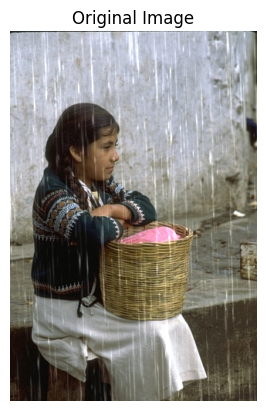

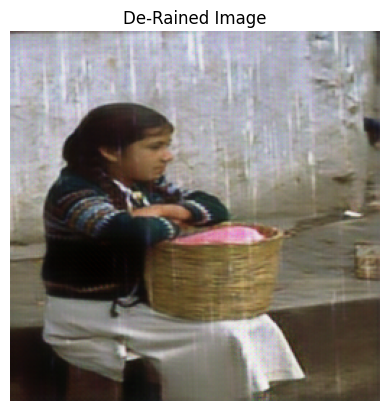

SSIM Score: 0.6967
PSNR Score: 29.43 dB
Inference complete! De-rained image saved.


In [5]:
import torch
from PIL import Image
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from models.networks import ResnetGenerator
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim


#  Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_G_A = ResnetGenerator(input_nc=3, output_nc=3, ngf=128, norm_layer=torch.nn.InstanceNorm2d, n_blocks=9).to(device)
checkpoint = torch.load("/content/drive/MyDrive/Khabeer - IRP/Dataset/checkpoint_3/final_trained_model_1.pth", map_location=device)
model_G_A.load_state_dict(checkpoint['model_G_A_state_dict'])
model_G_A.eval()

# Define image transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load new rainy image
image_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Rain100L/input/52.png"
img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

with torch.no_grad():
    de_rained_tensor = model_G_A(img_tensor)

#  Convert back to an image
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)
de_rained_tensor = de_rained_tensor * std + mean  # Denormalization
de_rained_tensor = torch.clamp(de_rained_tensor, 0, 1)

# Save the de-rained image
de_rained_image = to_pil_image(de_rained_tensor.squeeze(0).cpu())

de_rained_image_path = "/content/drive/MyDrive/Khabeer - IRP/Dataset/Test/52_de_rained.png"
de_rained_image.save(de_rained_image_path)

def calculate_psnr(img1, img2):
    """Compute Peak Signal-to-Noise Ratio (PSNR)"""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    """Compute Structural Similarity Index (SSIM)"""
    return ssim(img1, img2, data_range=img2.max() - img2.min())  #

# Paths to images

# Load images
input_img = cv2.imread(image_path)
de_rained_img = cv2.imread(de_rained_image_path)

# Resize de-rained image to match input image dimensions
de_rained_img = cv2.resize(de_rained_img, (input_img.shape[1], input_img.shape[0]))

# Convert to grayscale
input_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
de_rained_gray = cv2.cvtColor(de_rained_img, cv2.COLOR_BGR2GRAY)

#  Compute SSIM correctly (Grayscale)
ssim_score = calculate_ssim(input_gray, de_rained_gray)

# Compute PSNR in grayscale (for consistency)
psnr_score = calculate_psnr(input_gray, de_rained_gray)


plt.imshow(img)
plt.axis('off')
plt.title("Original Image")
plt.show()

plt.imshow(de_rained_image)
plt.axis('off')
plt.title("De-Rained Image")
plt.show()

# Print results
print(f"SSIM Score: {ssim_score:.4f}")
print(f"PSNR Score: {psnr_score:.2f} dB")

print("Inference complete! De-rained image saved.")
